In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from acoustools.BEM import load_scatterer, get_cache_or_compute_H, propagate_BEM_pressure, compute_E
from acoustools.Utilities import create_points, TOP_BOARD
from acoustools.Solvers import wgs
import csv

In [3]:
# Parameters
path = "C:/Users/Abdullah Saeed/Documents/BEMMedia"
csv_name = "pressure_test_data.csv"
board = TOP_BOARD

# Load reflector
reflector_type_names = ["flat", "Nonflat"] # stl files should be in format "{name}-lam{i}.stl" - store name here
lambda_start = 1 # lowest i value for stl files
lambda_end = 2 # highest i value for stl files

In [4]:
# Create empty CSV file or clear existing one
with open(csv_name, mode="w", newline="") as file:
    pass

# Generate single point
p = create_points(1,1,x=0,y=0,z=1) # change point coordinates here

pressures = []

# Loop through each type of reflector
for reflector_type in reflector_type_names:
    pressure_list = []

    path_list = [f"/{reflector_type}-lam{i}.stl" for i in range(lambda_start, lambda_end+1)]

    # For each reflector in that type, compute and store pressure data
    for reflector_path in path_list:
        print(f"Now testing reflector: {reflector_path}...")
        reflector = load_scatterer(path+reflector_path, dz=-0.05)
        
        H = get_cache_or_compute_H(reflector, TOP_BOARD,path=path)
        E = compute_E(reflector,points=p,board=TOP_BOARD,path=path,H=H)
        x = wgs(p,A=E)

        pressure = propagate_BEM_pressure(x,p,reflector,TOP_BOARD,path=path,H=H)
        # print(f"{reflector_path}: {pressure}")

        # Store pressures in CSV
        with open(csv_name, mode="a", newline="") as file:
            writer = csv.writer(file)
            
            # Write each row with format: stl_name, height, n, pressure1, pressure2, ...
            clean_pressures = pressure.view(-1).tolist()
            writer.writerow([reflector_path] + clean_pressures)

        pressure_list.append(pressure)
    pressures.append(pressure_list)

Now testing reflector: /flat-lam1.stl...
Now testing reflector: /flat-lam2.stl...
Now testing reflector: /Nonflat-lam1.stl...
Now testing reflector: /Nonflat-lam2.stl...


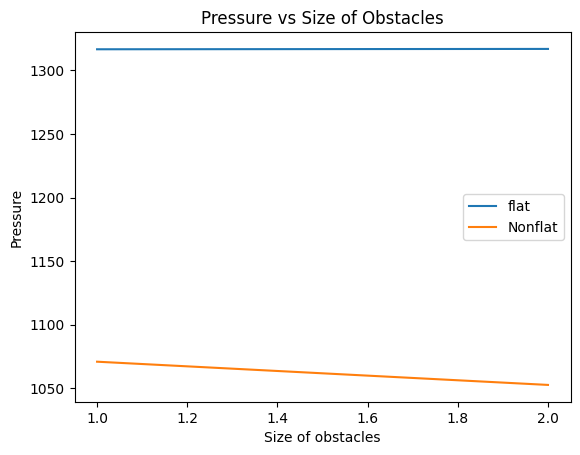

In [5]:
# Clean data for plotting
clean_pressures = [[float(val) for val in torch.cat(sublist).flatten()] for sublist in pressures]
sizes = list(range(lambda_start, lambda_end + 1))

# Plot results (1 line for each type of reflector)
# Graph of pressures vs size of obstacles
fig, ax = plt.subplots()
for i, pressure_list in enumerate(clean_pressures):
    ax.plot(sizes, pressure_list, label=reflector_type_names[i])
ax.legend()
plt.xlabel("Size of obstacles")
plt.ylabel("Pressure")
plt.title("Pressure vs Size of Obstacles")
plt.show()